In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import scipy.linalg as la
from  scipy.interpolate import interp1d
import fitsio

In [2]:
# some global constants used in the functions below
Nside = 64
Npix = 12*Nside**2
theta_map, phi_map = hp.pix2ang(Nside,np.arange(Npix))
lmax = 45

# reads azimuthally-symmetric beam format and then interpolates it onto the sphere 
def read_beam(fname):
    data = open(fname).readlines()[1:]
    data = np.array([[float(x) for x in d.split(',')] for d in data])
    data = np.array(data)
    data = data[data[:,0]==5] ## pick some phi
    gain_theta = interp1d (data[:,1]/180*np.pi,data[:,2])
    B = gain_theta(theta_map)
    return B

def mean_alm(alm1, alm2):
    prod = alm1*np.conj(alm2)
    sm = (np.real(prod[:lmax+1]).sum()+2*np.real(prod[lmax+1:]).sum())/(4*np.pi)
    return sm

def get_mean_vec(alm):
    return alm2rvec(np.hstack((alm[:lmax+1],2*alm[lmax+1:]))/(4*np.pi))

def alm2rvec (alm):
    return np.hstack((np.real(alm[:lmax+1]),np.real(alm[lmax+1:]),np.imag(alm[lmax+1:])))

def rvec2alm (rvec):
    f=rvec[:lmax+1]
    s,si = (rvec[lmax+1:].reshape((2,-1)))
    return np.hstack((f.astype(complex),s+1j*si))


def rotate_2beam(m,phi_d,dec_d,D,NS,phase):
    r=hp.Rotator(rot=[0, 90-dec_d, phi_d], eulertype='Y')
    mr = r.rotate_map_alms(m*np.cos(2*np.pi*D*np.sin(theta_map)*np.sin(phi_map+NS)+phase))
    return mr

def rotate_phi(malm, phi):
    r=hp.Rotator(rot=[0, 0, phi], eulertype='Y')
    return r.rotate_alm(malm)

/home/zack/.local/lib/python3.9/site-packages/healpy/visufunc.py:329: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.draw()
/home/zack/bin/anaconda3/envs/lusee/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


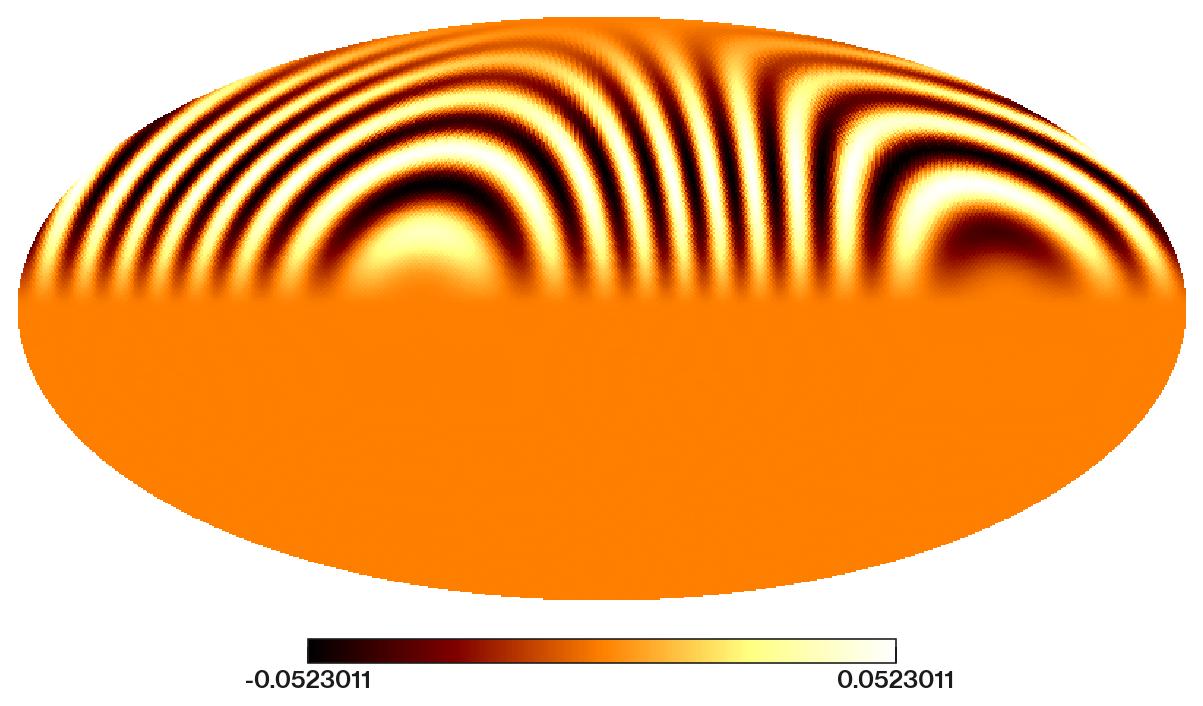

In [3]:
B0=read_beam('GainPlot_FIORE_Moon_05MHz_monopole_6m.csv')
B = rotate_2beam(B0,0,90,5,0.6,np.pi/2)
hp.mollview(B,title="",cmap='afmhot')

In [4]:
B = rotate_2beam(B0,50,-23,5,0.6,np.pi/2)

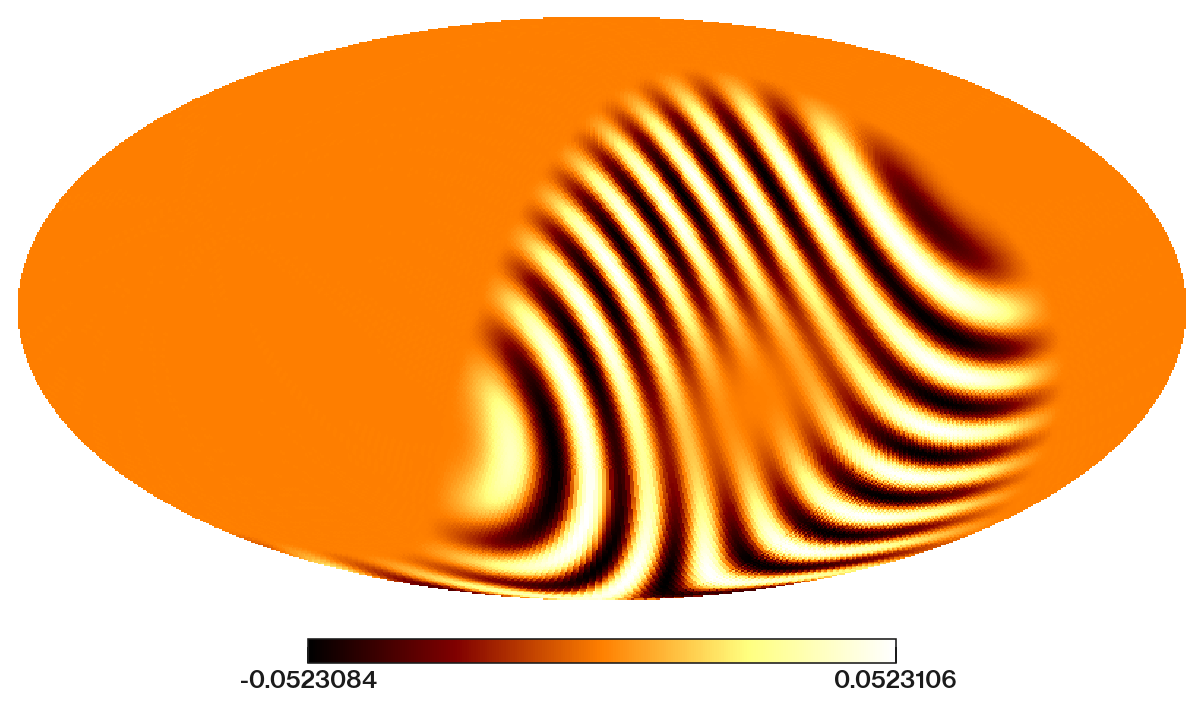

In [5]:
hp.mollview(B,title="",cmap='afmhot')
Bl = hp.map2alm(B,lmax=lmax)

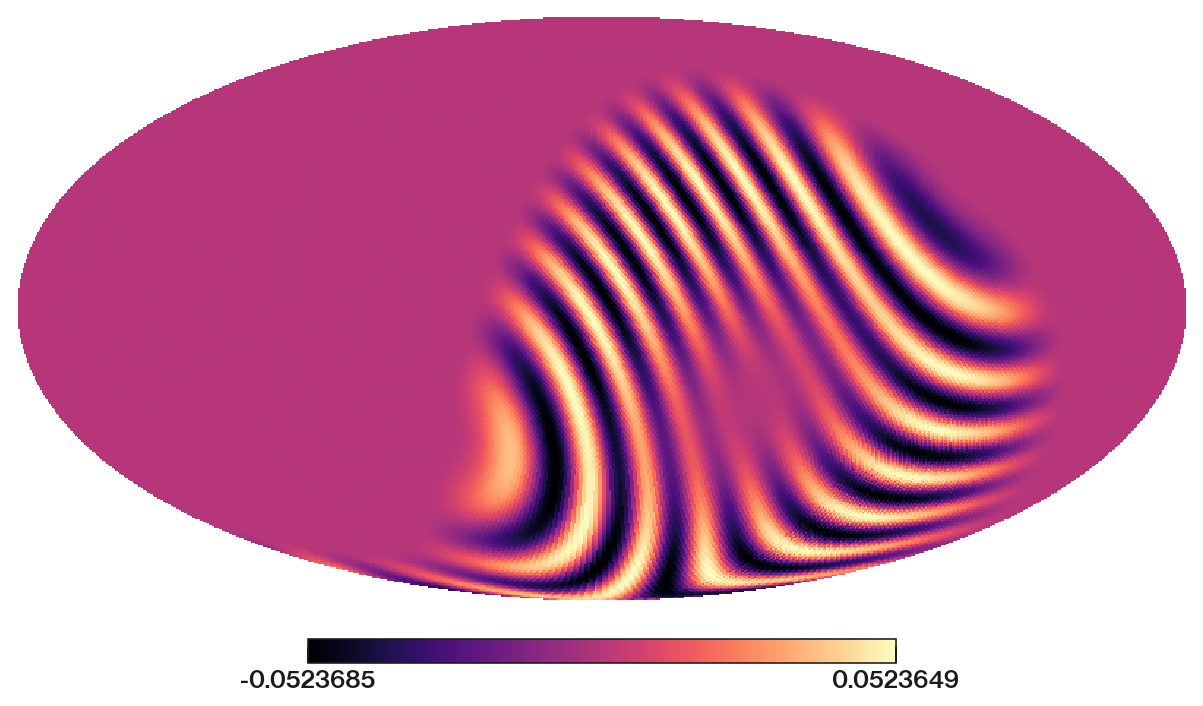

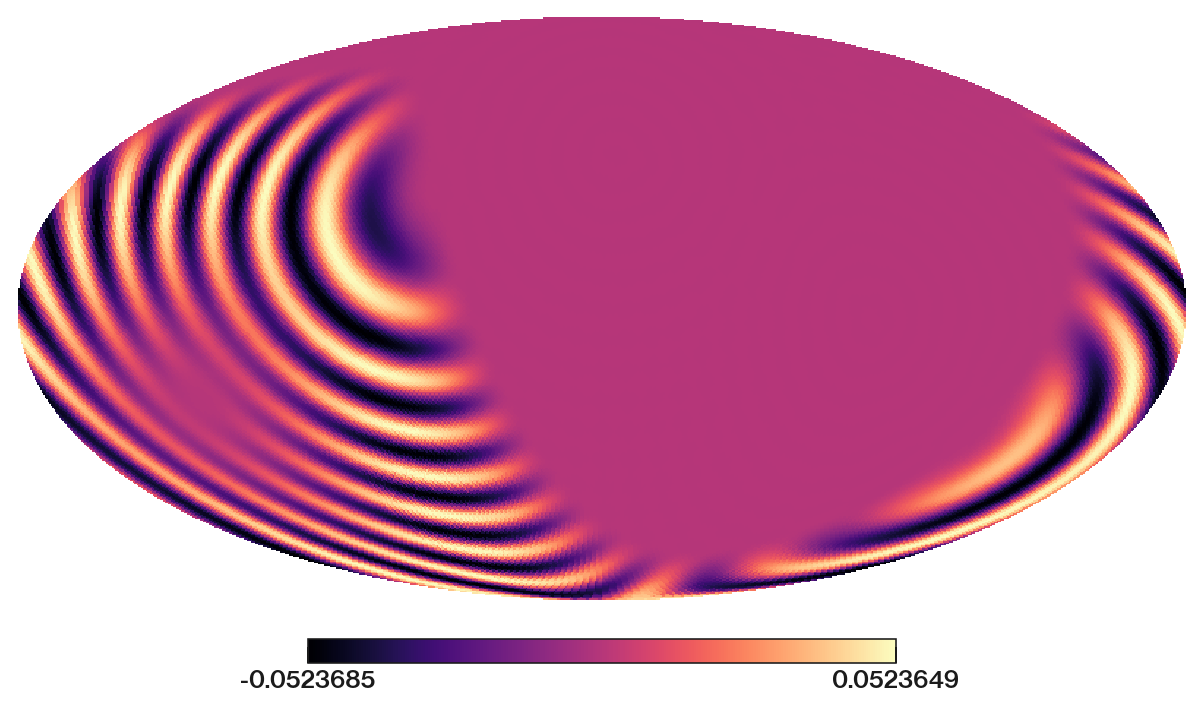

In [6]:
hp.mollview(hp.alm2map(Bl,nside=Nside),title="")
hp.mollview(hp.alm2map(rotate_phi(Bl,180),nside=Nside),title="")

50


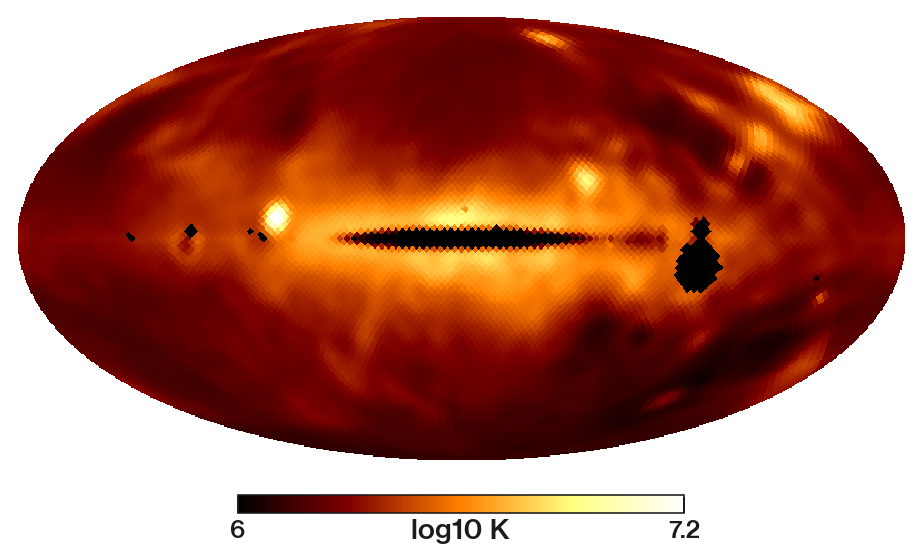

In [7]:
mpG = fitsio.read('ULSA_32_ddi_smooth.fits')
print (len(mpG))
mpG = mpG[4,:]
plt.figure(figsize=(8,6))
hp.mollview(np.log10(mpG),hold=True, title="",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')

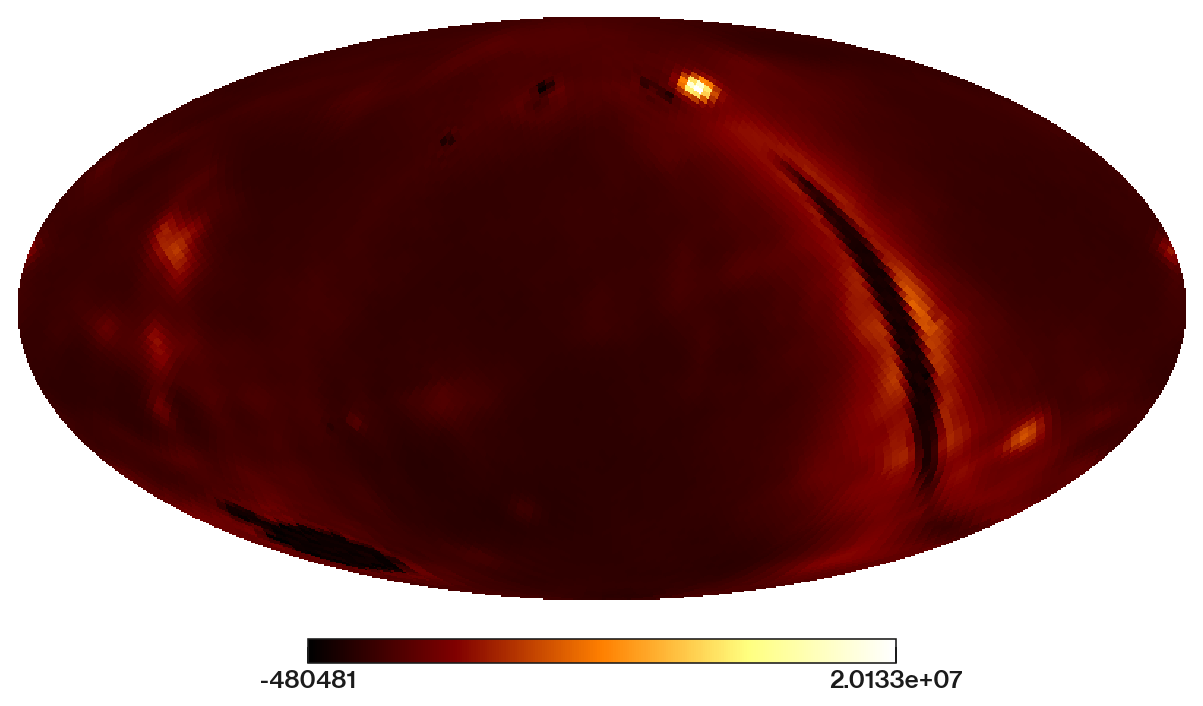

In [8]:
mp = hp.Rotator(coord=['G','E']).rotate_map_alms(mpG)
hp.mollview(mp,cmap='afmhot',title="")


In [9]:
mpl = hp.map2alm(mp,lmax=lmax)

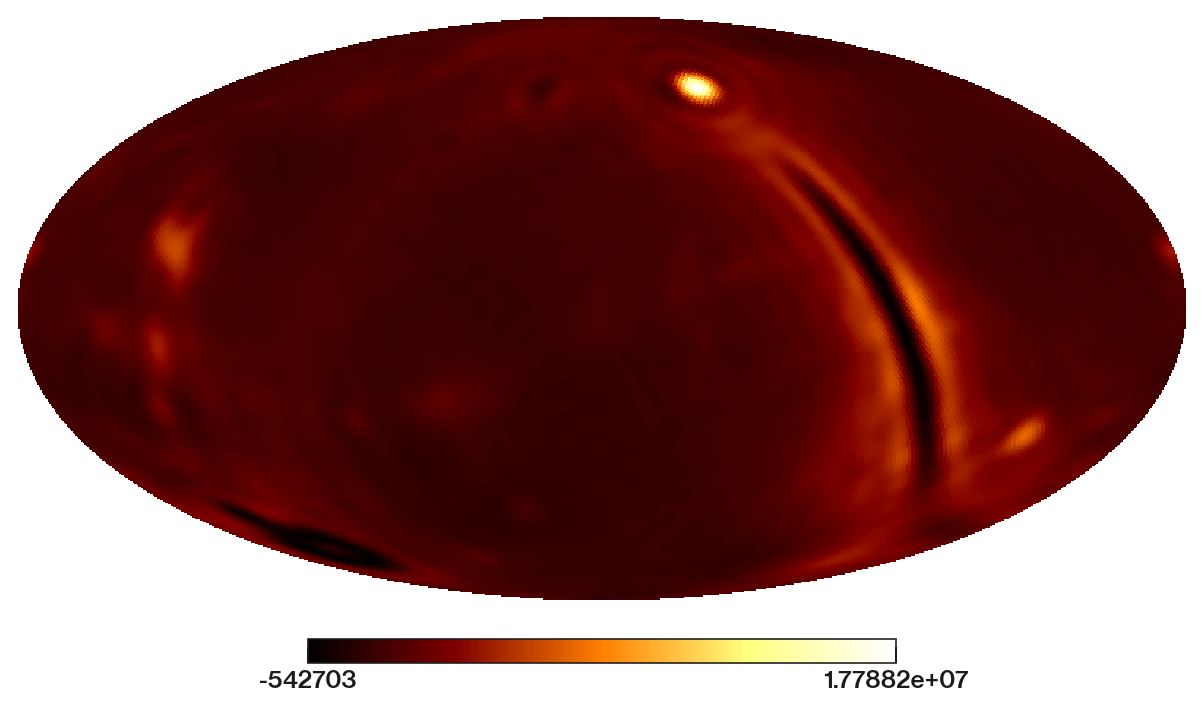

In [10]:
hp.mollview(hp.alm2map(mpl,nside=Nside),title="",cmap='afmhot')

In [11]:
def get_map(beamsl,phil, totint = 200):

    ## build the A matrix
    A= []
    for Bl,phir in zip(beamsl,phil):
        #print(phir)
        for phi in phir:
            Br = rotate_phi(Bl,phi)
            line = get_mean_vec(Br)
            A.append(line)
    A=np.array(A)
    xt = alm2rvec(mpl)
    
    ## now get SNR matrix and N matrix
    ellndx = []
    for l in range(lmax+1):
        ellndx.append(np.arange(l,lmax+1))
    for l in range(1,lmax+1):
        ellndx.append(np.arange(l,lmax+1))
    ellndx = np.hstack(ellndx)
    Sell = [(xt[ellndx==l_]**2).mean() for l_ in range(lmax+1)]
    Sdiag = np.array([Sell[l_] for l_ in ellndx])
    tint = (totint*3600/A.shape[0])#*2 # auto and cross
    data =np.dot(A,xt)
    Ndiag = (data**2)/(1e6* tint)
    noise = np.random.normal(0,1,len(data))*np.sqrt(Ndiag)

    S = np.diag(Sdiag)
    N = np.diag(Ndiag)
    Ni = np.diag(1/Ndiag)
    Si = np.diag(1/Sdiag)
    print (S.shape, N.shape)
    
    ## now get the weight matrix
    if S.shape[0]<N.shape[0]:
        T = A.T@Ni@A+Si
        W = la.inv(T)@A.T@Ni
    else:
        W = S@A.T@la.inv(A@S@A.T+N)
    ## and multiply
    res = np.dot(W,data+noise)
    
    ## and make a map
    mapp = hp.alm2map(rvec2alm(res),nside=Nside)
    return mapp

In [19]:
beams = []
rotmax=360*2+270
xl,yl=[],[]
phiofs = -60
phimax = 100
phil = []
steps = 100
Dofs = 0
Dmax = 5
Ndays = 1
for c, ns in enumerate(np.linspace(0, rotmax**(3),steps)):
    ns=ns**(1/3)
    D = Dofs+ns/rotmax * (Dmax-Dofs)
    if (c==0):
        D=0
    xl.append(D*np.cos(ns/180*np.pi))
    yl.append(D*np.sin(ns/180*np.pi))
    for phase in [0,np.pi/2]:
        mr = rotate_2beam(B0,0,-23,D, ns, phase)
        beams.append(mr)
        philx = []
        for days in range(Ndays):
            if D==0:
                philx.append(np.linspace(phiofs+days*30,phiofs+phimax,steps))
            else:
                cstart= phiofs+days*30+c/steps*phimax
                cend = phiofs+days*30+(c+1)/steps*phimax
                philx.append(np.linspace(cstart,cend,10))
        phil.append(np.hstack(philx))

beamsl = [hp.map2alm(b,lmax=lmax) for b in beams]

42.34749150701196 25.408494904207178


(-320.0, 320.0)

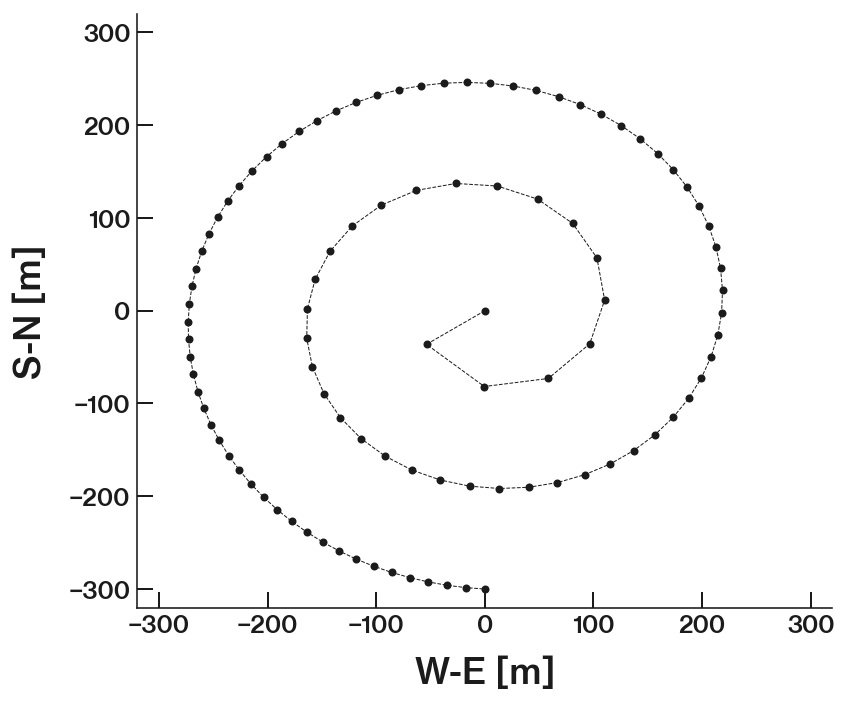

In [22]:
def get_beamsl(B0_in):
    beams = []
    rotmax=360*2+270
    xl,yl=[],[]
    phiofs = -60
    phimax = 100
    phil = []
    steps = 100
    Dofs = 0
    Dmax = 5
    Ndays = 1
    for c, ns in enumerate(np.linspace(0, rotmax**(3),steps)):
        ns=ns**(1/3)
        D = Dofs+ns/rotmax * (Dmax-Dofs)
        if (c==0):
            D=0
        xl.append(D*np.cos(ns/180*np.pi))
        yl.append(D*np.sin(ns/180*np.pi))
        for phase in [0,np.pi/2]:
            mr = rotate_2beam(B0_in,0,-23,D, ns, phase)
            beams.append(mr)
            philx = []
            for days in range(Ndays):
                if D==0:
                    philx.append(np.linspace(phiofs+days*30,phiofs+phimax,steps))
                else:
                    cstart= phiofs+days*30+c/steps*phimax
                    cend = phiofs+days*30+(c+1)/steps*phimax
                    philx.append(np.linspace(cstart,cend,10))
            phil.append(np.hstack(philx))

    beamsl = [hp.map2alm(b,lmax=lmax) for b in beams]
    return beamsl, phil

beamsl, phil = get_beamsl(B0)

# assert(len(phil)==len(beamsl))

lam_m = 3e8/5e6
xl = np.array(xl)
yl = np.array(yl)
dd = np.sqrt(((xl[1:]-xl[:-1])**2+(yl[1:]-yl[:-1])**2)).sum()
tdrive = dd*lam_m/100 # in hours
print (dd,dd*lam_m/100)

plt.figure(figsize=(6,5))
#plt.subplot(1,2,1)
plt.plot(xl*lam_m,yl*lam_m,'o--',lw=0.5,ms=3,
         label=f'phiofs ={phiofs}\nphimax = {phimax}\nwait = {phimax/360*28*24/steps}h')
plt.xlabel('W-E [m]')
plt.ylabel('S-N [m]')
plt.xlim(-320,320)
plt.ylim(-320,320)
# plt.legend()
#plt.subplot(1,2,2)

In [23]:
sol = get_map(beamsl,phil,totint = Ndays*(220-tdrive))

(2116, 2116) (2180, 2180)


In [24]:
# reads azimuthally-symmetric beam format and then interpolates it onto the sphere 
def read_beam(fname, pert):
    data = open(fname).readlines()[1:]
    data = np.array([[float(x) for x in d.split(',')] for d in data])
    data = np.array(data)
    data = data[data[:,0]==5] ## pick some phi
    gain_theta = interp1d (data[:,1]/180*np.pi,data[:,2])
    B = gain_theta(theta_map) * pert(theta_map)
    return B

Text(0.5, 0, 'theta')

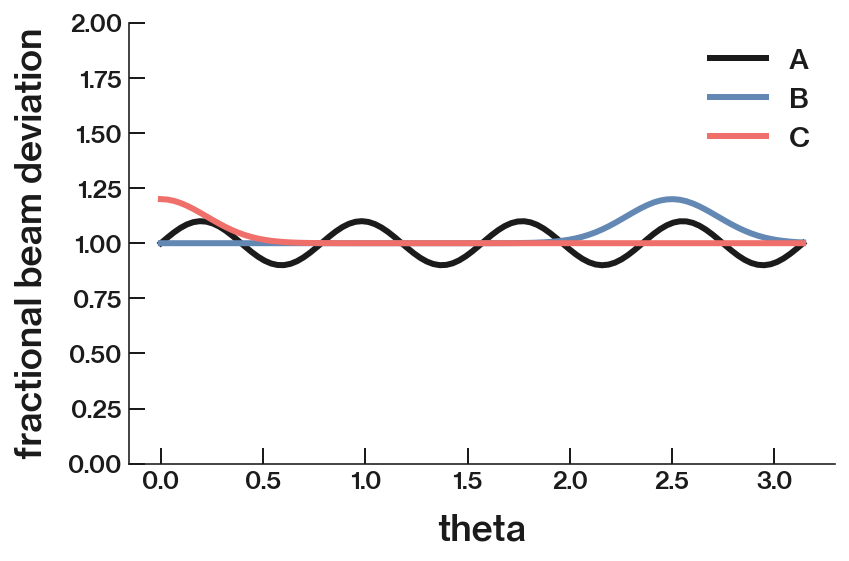

In [93]:
thetas = np.linspace(0, np.pi, 100)

systematic_pert_A = interp1d (thetas, 1 + 0.1 * np.sin(8 * thetas) )
systematic_pert_B = interp1d (thetas, 1 + 0.2 * np.exp( -( thetas - 2.5 )**2 / 0.1 ) )
systematic_pert_C = interp1d (thetas, 1 + 0.2 * np.exp( -( thetas - 0.0 )**2 / 0.1 ) )

plt.plot(thetas, systematic_pert_A(thetas), label="A")
plt.plot(thetas, systematic_pert_B(thetas), label="B")
plt.plot(thetas, systematic_pert_C(thetas), label="C")

plt.legend()
plt.ylim(0,2)
plt.ylabel("fractional beam deviation")
plt.xlabel("theta")

In [94]:
sol_perts_ABC = [get_map(
    get_beamsl(read_beam('GainPlot_FIORE_Moon_05MHz_monopole_6m.csv', systematic_pert))[0],
    phil,totint = Ndays*(220-tdrive))
                for systematic_pert in [systematic_pert_A, systematic_pert_B, systematic_pert_C]
]

(2116, 2116) (2180, 2180)
(2116, 2116) (2180, 2180)
(2116, 2116) (2180, 2180)


In [95]:
tsol = hp.alm2map(mpl,nside=Nside)

In [96]:
[np.std(tsol - sol_pert) / np.std(tsol - sol) for sol_pert in sol_perts_ABC] 

[0.9836668001816739, 1.0032282973930184, 1.0070957656564343]

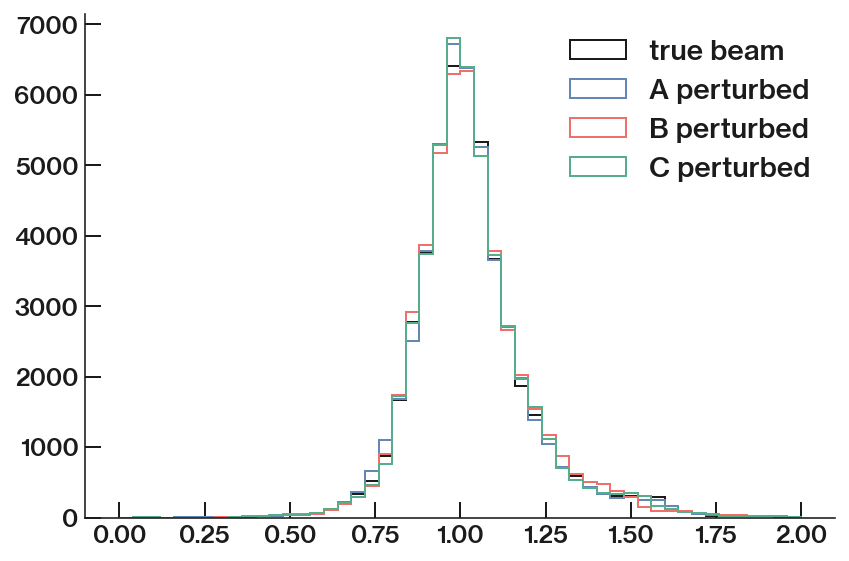

In [97]:
plt.hist(sol / tsol, range=(0.0, 2.0), bins=50, histtype="step", label="true beam")

for sol_pert, label in zip(sol_perts_ABC, ["A", "B", "C"]):
    plt.hist( (sol_pert) / tsol, range=(0.0, 2.0), bins=50, histtype="step", label=f"{label} perturbed")
    
plt.legend()

/tmp/ipykernel_581755/3305563812.py:3: RuntimeWarning: invalid value encountered in log10
  hp.mollview(np.log10(tsol),hold=True, title="true",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')
/tmp/ipykernel_581755/3305563812.py:5: RuntimeWarning: invalid value encountered in log10
  hp.mollview(np.log10(sol_perts_ABC[0]),hold=True, title="A",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')
/tmp/ipykernel_581755/3305563812.py:7: RuntimeWarning: invalid value encountered in log10
  hp.mollview(np.log10(sol_perts_ABC[1]),hold=True, title="B",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')
/tmp/ipykernel_581755/3305563812.py:9: RuntimeWarning: invalid value encountered in log10
  hp.mollview(np.log10(sol_perts_ABC[2]),hold=True, title="C",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')


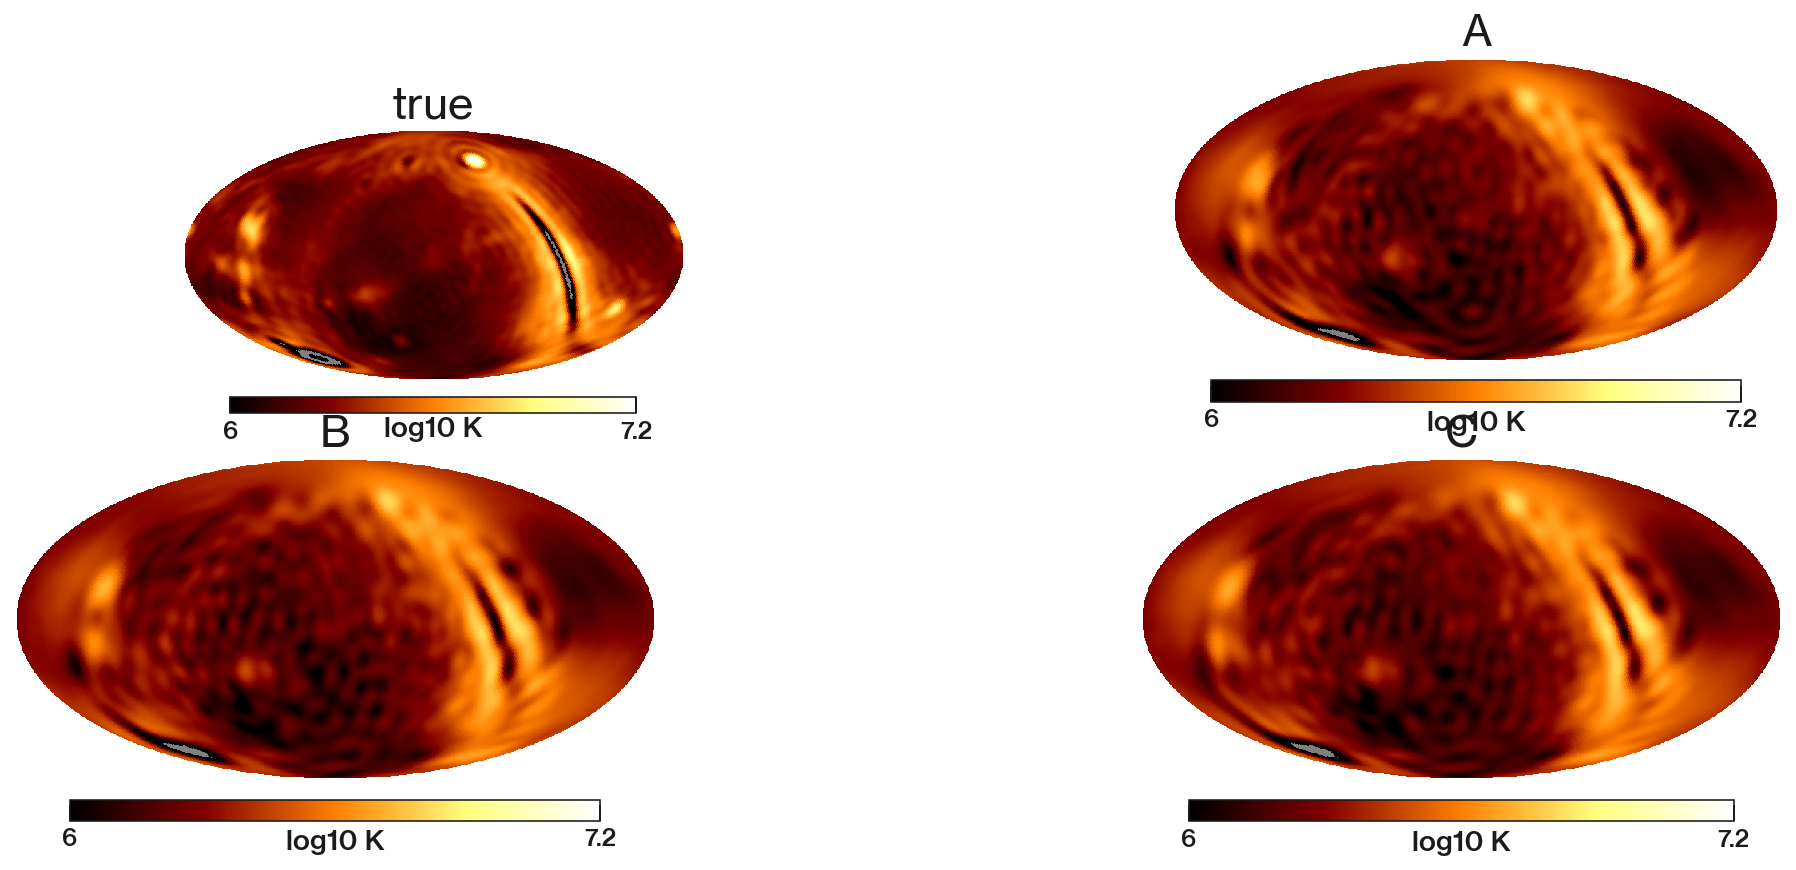

In [122]:

fig, axes = plt.subplots(2,2,figsize=(16,6))
plt.axes(axes[0,0])
hp.mollview(np.log10(tsol),hold=True, title="true",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')
plt.axes(axes[0,1])
hp.mollview(np.log10(sol_perts_ABC[0]),hold=True, title="A",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')
plt.axes(axes[1,0])
hp.mollview(np.log10(sol_perts_ABC[1]),hold=True, title="B",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')
plt.axes(axes[1,1])
hp.mollview(np.log10(sol_perts_ABC[2]),hold=True, title="C",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')


In [78]:
# hp.mollview(np.log10(sol_pert),hold=True, title="",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')

In [79]:
# sol[sol<0]=1e-3
# # plt.figure(figsize=(8,6))
# #hp.mollview(sol,hold=True, title="")
# hp.mollview(np.log10(sol),hold=True, title="",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')

In [80]:
# # plt.figure(figsize=(8,6))
# #hp.mollview(hp.alm2map(mpl,nside=Nside),hold=True, min=0, max=1.1e7,title="")
# tsol = hp.alm2map(mpl,nside=Nside)
# tsol[tsol<0]=1
# hp.mollview(np.log10(tsol),hold=True, title="",min=6.0,max=7.2,unit='log10 K',cmap='afmhot')

In [81]:
# plt.figure(figsize=(8,6))
# #hp.mollview(hp.alm2map(mpl,nside=Nside),hold=True, min=0, max=1.1e7,title="")
# tsol = hp.alm2map(mpl,nside=Nside)
# tsol[tsol<0]=1
# hp.mollview(tsol,hold=True, title="",unit='log10 K',cmap='afmhot')

/home/zack/.local/lib/python3.9/site-packages/healpy/visufunc.py:329: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.draw()
/home/zack/bin/anaconda3/envs/lusee/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


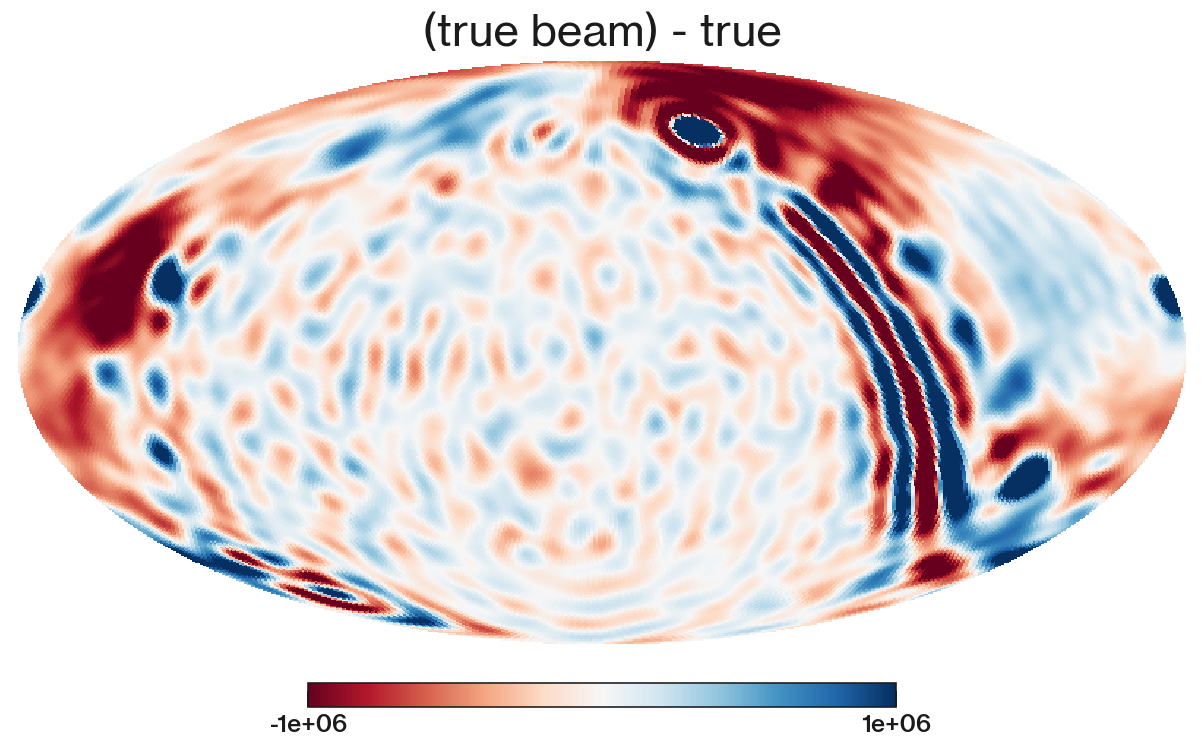

In [89]:
hp.mollview(tsol - sol,cmap='RdBu', min=-1e6, max=1e6, title="(true beam) - true")

In [101]:
# hp.mollview(tsol,cmap='RdBu',title="(beam biased by pert A) - true")

In [102]:
# 1],cmap='RdBu', min=-1e6, max=1e6, title="(beam biased by pert A) - true")

In [103]:
# hp.mollview(tsol - sol_pert[2],cmap='RdBu', min=-1e6, max=1e6, title="(beam biased by pert A) - true")